## Helper Notebook to Inspect  PNW Dataset





- All waveform data downloaded from [IRIS DMC](https://ds.iris.edu/ds/nodes/dmc/).
- Events and phase information are downloaded from [ANSS/ComCat](https://earthquake.usgs.gov/data/comcat/) using [libcomcat](https://github.com/usgs/libcomcat).

---
 ##### Yiyu Ni (niyiyu@uw.edu)
 ##### Earth and Space Sciences
 ##### University of Washington

In [34]:
# some modules are not intalled in google colab by default.
!pip install obspy scipy wget

zsh:1: command not found: pip


In [35]:
# import all required packages

# suppress pandas future warnings
import warnings
warnings.simplefilter(action = 'ignore', 
                      category = FutureWarning)

import h5py
import wget
import obspy
import pandas as pd
import numpy as np

# plotting libraries
import matplotlib
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# datetime interaction
from datetime import datetime
from datetime import timedelta as dt
from obspy.core.utcdatetime import UTCDateTime

In [111]:
def interactive_plotting(df, index, seconds_before = 3, seconds_after = 3, apply_filter = None, freq = None, freqmax = None, freqmin = None):
    net = df.loc[index, 'station_network_code']
    sta = df.loc[index, 'station_code']
    cha = df.loc[index, 'station_channel_code']
    sample_p = df.loc[index, 'trace_P_arrival_sample']
    sample_s = df.loc[index, 'trace_S_arrival_sample']
    trace_starttime = df.loc[index, 'trace_start_time']
    sample_rate = df.loc[index, 'trace_sampling_rate_hz']
    etp = df.loc[index, 'source_type']
    tn = df.loc[index]['trace_name']
    bucket, narray = tn.split('$')
    x, _, _ = iter([int(i) for i in narray.split(',:')])
    data = f['/data/%s' % bucket][x, :, :]

    stream = obspy.Stream()
    for i in range(3):
        tr = obspy.Trace()
        tr.data = data[i, :]
        tr.stats.sampling_rate = df.iloc[index]['trace_sampling_rate_hz']
        stream.append(tr)
    
    if apply_filter == 'bandpass':
        stream.filter(apply_filter, freqmin = freqmin, freqmax = freqmax)
    elif apply_filter is not None:
        stream.filter(apply_filter, freq = freq)

    starttime = datetime.utcfromtimestamp(UTCDateTime(trace_starttime).timestamp)
    if etp in ['earthquake', 'explosion']:
        x = [starttime + dt(seconds = i/sample_rate) for i in np.arange(15001)]
    else:
        x = [starttime + dt(seconds = i/sample_rate) for i in np.arange(18001)]
    if not np.isnan(sample_p):
        p_time = [(starttime + dt(seconds = sample_p/sample_rate)) for _ in range(10)]
    if not np.isnan(sample_s):
        s_time = [(starttime + dt(seconds = sample_s/sample_rate)) for _ in range(10)]
    plt.figure(figsize = (12, 10), dpi = 100)
    myFmt = mdates.DateFormatter('%X.%S')
    plt.subplots_adjust(hspace = 0.2)
    plt.subplot(2, 1, 1)
    plt.title("%s: %s.%s..%s" % (etp, net, sta, cha), fontsize = 20)
    plt.plot(x, np.array(stream).T, '.-', markersize = 2, linewidth = 1)
    plt.grid(True)
    if not np.isnan(sample_p):
        plt.plot(p_time, np.linspace(-data.max(), data.max(), 10), 
                 'r--', label = 'PNSN P Pick', linewidth = 2)
        plt.xlim([p_time[0] - dt(seconds = seconds_before),  
              p_time[0] + dt(seconds = seconds_after)])   # Only look at seconds before/after arrival
        plt.legend(fontsize = 15)
    plt.gca().xaxis.set_major_formatter(myFmt)
    
    plt.subplot(2, 1, 2)
    plt.plot(x, np.array(stream).T, '.-', markersize = 2, linewidth = 1)
    plt.grid(True)
    if not np.isnan(sample_s):
        plt.plot(s_time, np.linspace(-data.max(), data.max(), 10), 
                 'k--', label = 'PNSN S Pick', linewidth = 2)
        plt.xlim([s_time[0] - dt(seconds = seconds_before),  
              s_time[0] + dt(seconds = seconds_after)])   # Only look at seconds before/after arrival
        plt.legend(fontsize = 15)
    plt.gca().xaxis.set_major_formatter(myFmt)

## Load the micro PNW dataset
- A mini version of PNW is available at project repository at https://github.com/niyiyu/PNW-ML. This package contains 50 3C waveforms from earthquake, explosion, surface event, sonic boom and thunder storm (10 streams each).
- This dataset follows the structure of [seisbench](https://seisbench.readthedocs.io/en/latest/). See [here](https://seisbench.readthedocs.io/en/latest/pages/data_format.html) to learn more about the  file structure.

In [45]:
wget.download("https://raw.githubusercontent.com/niyiyu/PNW-ML/main/data/microPNW/microPNW_metadata.csv")
wget.download("https://raw.githubusercontent.com/niyiyu/PNW-ML/main/data/microPNW/microPNW_waveforms.hdf5")

'microPNW_waveforms.hdf5'

In [53]:
f = h5py.File("./microPNW_waveforms.hdf5", "r")
df = pd.read_csv("./microPNW_metadata.csv")

## each column is labelled by one of the keys of the metadata

In [54]:
df.keys()

Index(['event_id', 'source_origin_time', 'source_latitude_deg',
       'source_longitude_deg', 'source_type', 'source_depth_km',
       'preferred_source_magnitude', 'preferred_source_magnitude_type',
       'preferred_source_magnitude_uncertainty', 'source_depth_uncertainty_km',
       'source_horizontal_uncertainty_km', 'station_network_code',
       'station_channel_code', 'station_code', 'station_location_code',
       'station_latitude_deg', 'station_longitude_deg', 'station_elevation_m',
       'trace_name', 'trace_sampling_rate_hz', 'trace_start_time',
       'trace_S_arrival_sample', 'trace_P_arrival_sample',
       'trace_S_arrival_uncertainty_s', 'trace_P_arrival_uncertainty_s',
       'trace_P_polarity', 'trace_S_onset', 'trace_P_onset', 'trace_snr_db',
       'source_type_pnsn_label', 'source_local_magnitude',
       'source_local_magnitude_uncertainty', 'source_duration_magnitude',
       'source_duration_magnitude_uncertainty', 'source_hand_magnitude'],
      dtype='objec

## Do some stream selection only if necessary

In [55]:
df_filt = df

# df_filt = df_filt[df_filt['source_id'] == 'uw61631152']      # select a source id
df_filt = df_filt[df_filt['station_channel_code'] == 'EH']     # select channel code
# df_filt = df_filt[df_filt['station_network_code'] == 'UW']   # select network code
# df_filt = df_filt[df_filt['station_code'] == 'VLL']          # select station code

index = df_filt.index

## Specify an index by looking at the "index" column of filtered dataframe

In [88]:
# specify a index:
index = 31

df.loc[index]

event_id                                                  pnsn1451413
source_origin_time                                                NaN
source_latitude_deg                                               NaN
source_longitude_deg                                              NaN
source_type                                                   thunder
source_depth_km                                                   NaN
preferred_source_magnitude                                        NaN
preferred_source_magnitude_type                                   NaN
preferred_source_magnitude_uncertainty                            NaN
source_depth_uncertainty_km                                       NaN
source_horizontal_uncertainty_km                                  NaN
station_network_code                                               CC
station_channel_code                                               BH
station_code                                                     NORM
station_location_cod

## Interactive plotting stream
**Note that interactive plotting is not available at Google Colab**

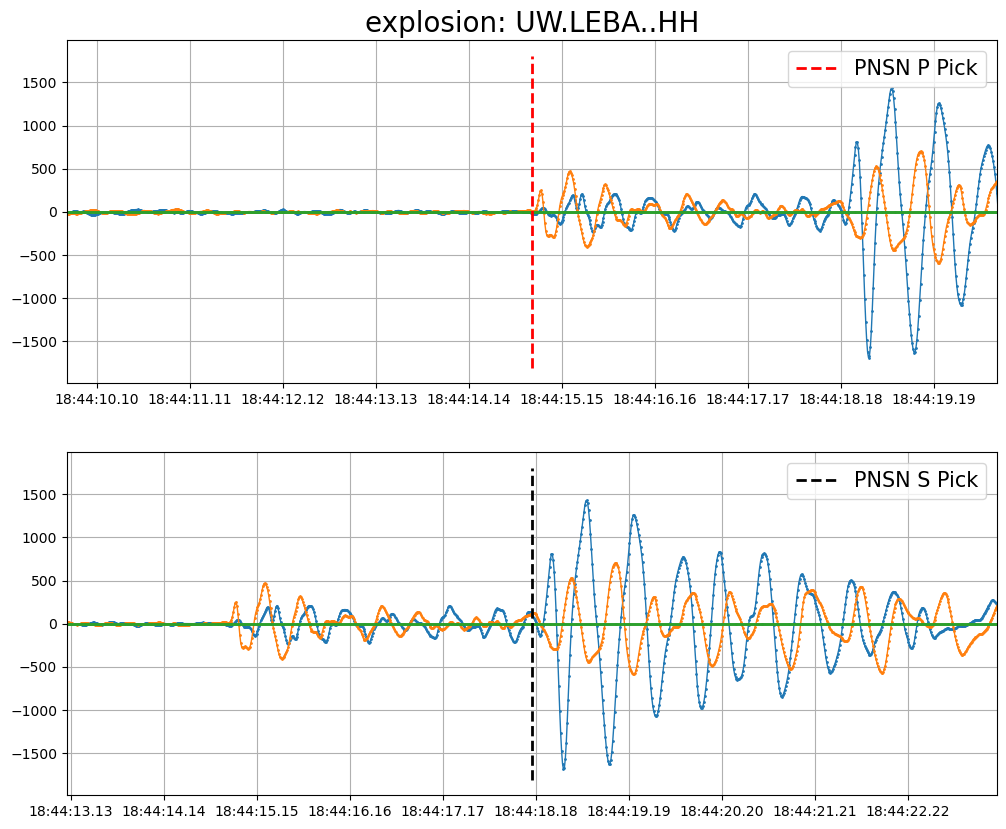

In [114]:
# %matplotlib notebook
i = 10

interactive_plotting(df, i, seconds_before = 5, seconds_after = 5,
                     apply_filter = 'bandpass', freqmax = 10, freqmin = 1)

# End of Notebook